In [3]:

from filterpy.kalman import IMMEstimator, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import numpy as np
import matplotlib.pyplot as plt
from dynamicSystem import simulateNonlinearSSM
from threeTank import getThreeTankEquations, ThreeTank, parameter as param
import GPy

from gpy.GP_BF import GP_SSM, init_GP_UKF

stateTransition, observation = getThreeTankEquations()

## optimal workflow

- for each Mode in IMM:
  - generate or load training Data
  - init gp state space model
  - train gaussian process
  - init bayes filter
- init interacting multiple model
- Test Loop

In [4]:
# init variables for IMM-GP-UKF

modeN = 2
stateN = 3
filters = []
mu = [0.5, 0.5]  # each filter is equally likely at the start
trans = np.array([[0.97, 0.03], [0.03, 0.97]])

dt = 1
z_std = 0.1

x = np.zeros(stateN) # initial state
P = 0.2 # initial uncertainty
R = np.diag([z_std**2, z_std**2, z_std**2]) # 1 standard
Q = Q_discrete_white_noise(dim=stateN, dt=dt, var=0.01**2, block_size=1) #TODO can also be standard noise of GP

# create sigma points to use in the filter. This is standard for Gaussian processes
points = MerweScaledSigmaPoints(stateN, alpha=.1, beta=2., kappa=-1)

#TODO throw error when size of mu and trans does not match modeN

# create training data through simulation
xData, yData, dxData, tsData = simulateNonlinearSSM(ThreeTank(), x, dt, 100)


# init IMM with GP-UKF filters
for i in range(modeN):

    gpModel = GP_SSM(dxData, yData, stateN)
    gpModel.optimize()

    filter = init_GP_UKF(x, gpModel.stateTransition, observation, points, gpModel.stateTransitionVariance, P, R, Q, dt)
    filters.append(filter)

immUkf = IMMEstimator(filters, mu, trans)

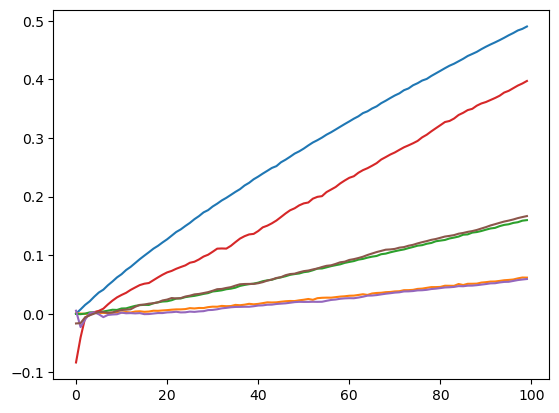

In [5]:
N = 100

#zs = [[i+randn()*z_std, i+randn()*z_std] for i in range(N)]
xSim, ySim, dxSim, tSim = simulateNonlinearSSM(ThreeTank(param), x, dt, N)

zValues =  ySim
xValues = np.zeros((3,N))

for i in range(N):
    # make some noisy data
    #z = [i + np.random.randn()*z_std, i + np.random.randn()*z_std]
    # y = i + np.random.randn()*np.sqrt(f2.R[1, 1])
    # z = np.array([[x], [y]])

    # perform predict/update cycle
    immUkf.predict()
    immUkf.update(zValues[:,i])

    # zValues[0,i] = z[0]
    # zValues[1,i] = z[1]
    # zValues[2,i] = z[2]

    xValues[0,i] = immUkf.x[0]
    xValues[1,i] = immUkf.x[1]
    xValues[2,i] = immUkf.x[2]

plt.figure()
plt.plot(zValues[0,:])
plt.plot(zValues[1,:])
plt.plot(zValues[2,:])

plt.plot(xValues[0,:])
plt.plot(xValues[1,:])
plt.plot(xValues[2,:])